# Anomaly detection in network traffic using AIML techniques


## Step 1: Import the Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, IsolationForest


## Step 2: Load and Inspect Data


In [15]:
# Load dataset
df = pd.read_csv("kdd_test.csv")  
# Check dataset
print(df.head())
print(df.info())

   duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0         5           tcp      smtp    SF       2429        475     0   
1         0           udp  domain_u    SF         45        134     0   
2         0           udp  domain_u    SF         45         80     0   
3      1979           udp     other    SF        145        105     0   
4     14462           tcp     other  RSTR          1          0     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  57   
1               0       0    0  ...                 155   
2               0       0    0  ...                 255   
3               0       0    0  ...                   2   
4               0       0    0  ...                   2   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.11                    0.02   
1                    0.80                    0.02   
2                    1.00                    0.

## Step 3: Simplify the Labels


labels
attack    11299
normal    11245
Name: count, dtype: int64


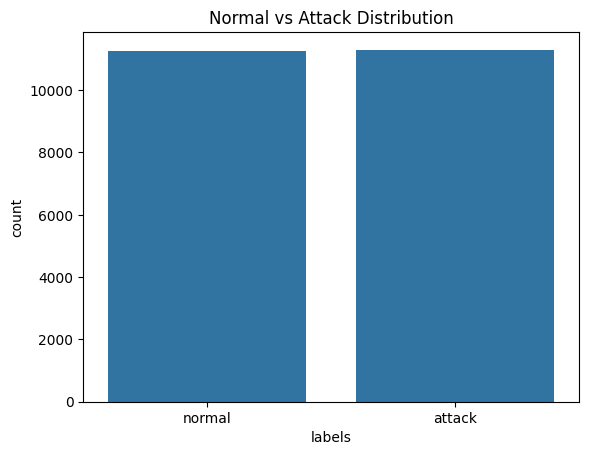

In [3]:
df['labels'] = df['labels'].apply(lambda x: 'normal' if x == 'normal' else 'attack')
print(df['labels'].value_counts())
sns.countplot(x='labels', data=df)
plt.title("Normal vs Attack Distribution")
plt.show()


## Step 4: Encode Categorical Columns

In [4]:
categorical_cols = ['protocol_type', 'service', 'flag']
encoder = LabelEncoder()

for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

print("Categorical columns encoded successfully.")


Categorical columns encoded successfully.


## Step 5: Split Features and Labels

In [5]:
X = df.drop(['labels'], axis=1)
y = df['labels']

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Step 6: Split into Train/Test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)


## Step 7: Supervised ML Model (Random Forest)

 Random Forest Accuracy: 0.9909816676522768

Classification Report:
               precision    recall  f1-score   support

      attack       0.99      0.99      0.99      3390
      normal       0.99      0.99      0.99      3374

    accuracy                           0.99      6764
   macro avg       0.99      0.99      0.99      6764
weighted avg       0.99      0.99      0.99      6764



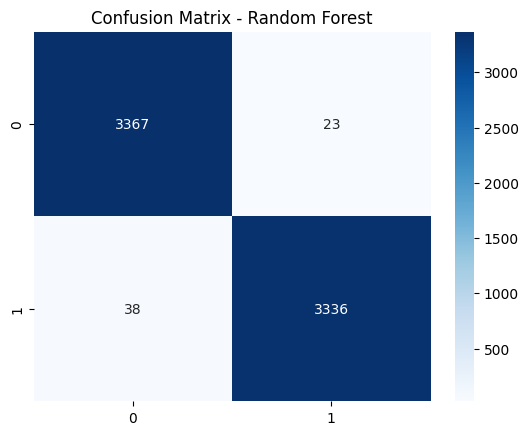

In [7]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(" Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()


## Step 8: Unsupervised Anomaly Detection

In [8]:
iso_forest = IsolationForest(contamination=0.2, random_state=42)
iso_pred = iso_forest.fit_predict(X_scaled)

# Convert predictions (-1=anomaly, 1=normal)
iso_pred = np.where(iso_pred == -1, 'attack', 'normal')

print("\n Isolation Forest Results:")
print(classification_report(y, iso_pred))



 Isolation Forest Results:
              precision    recall  f1-score   support

      attack       0.77      0.31      0.44     11299
      normal       0.57      0.91      0.70     11245

    accuracy                           0.61     22544
   macro avg       0.67      0.61      0.57     22544
weighted avg       0.67      0.61      0.57     22544



## Step 9: Visualize Feature Importance

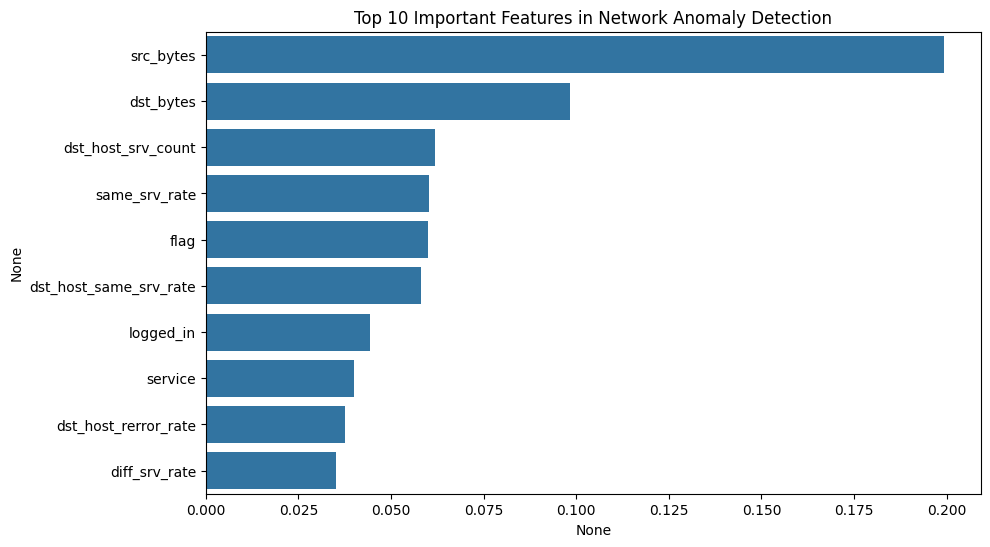

In [9]:
feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance[:10], y=feature_importance.index[:10])
plt.title("Top 10 Important Features in Network Anomaly Detection")
plt.show()


## Step 10: PCA Visualization of Anomalies

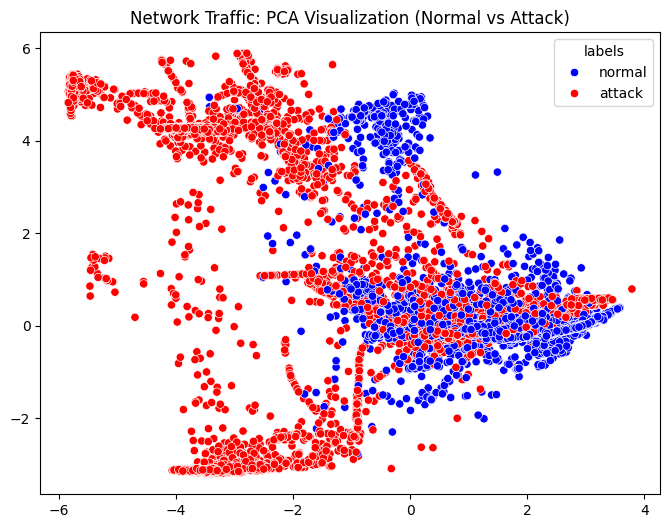

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_data[:,0], y=pca_data[:,1], hue=df['labels'], palette={'normal':'blue', 'attack':'red'})
plt.title("Network Traffic: PCA Visualization (Normal vs Attack)")
plt.show()


## Step 11: Unsupervised Model – Isolation Forest

In [11]:
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_pred = iso_forest.fit_predict(X_test)

# Convert predictions (-1 → anomaly, 1 → normal)
iso_pred = [0 if x == 1 else 1 for x in iso_pred]

print("Isolation Forest Detected Anomalies:", sum(iso_pred))


Isolation Forest Detected Anomalies: 677


## Step 12: Compare Predictions (Supervised vs Unsupervised)

In [12]:
comparison = pd.DataFrame({
    'Actual': y_test.values,
    'RF_Pred': y_pred,
    'ISO_Pred': iso_pred
})
comparison.head()


,Actual,RF_Pred,ISO_Pred
0,attack,attack,0
1,attack,attack,0
2,normal,normal,0
3,attack,attack,0
4,attack,attack,0


In [13]:
print(df['labels'].value_counts())


labels
attack    11299
normal    11245
Name: count, dtype: int64


In [14]:
df['labels'].str.strip().str.lower()


0        normal
1        normal
2        normal
3        normal
4        attack
          ...  
22539    attack
22540    normal
22541    attack
22542    attack
22543    normal
Name: labels, Length: 22544, dtype: object